In [204]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

# Descarga del target
# ==============================================================================
from google.colab import files

#Extra
# ==============================================================================
from datetime import datetime

In [205]:
# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

#Entrenamiento


## Hiper-parámetros


* **learning_rate:** tasa de aprendizaje
* **max_depth:** máxima profundidad de cada árbol
* **subsample:** porcentaje de muestras usadas para cada árbol (valor muy bajo, posible underfitting)
* **colsample_bytree:** porcentaje de features usadas para cada árbol (valores muy alto, posible overfitting)
* **n_estimators:** cantidad de árboles a construir.
* **objective:** función de error a utilizar (algunas: reg:squarederror para regresión, reg:logistic o binary:logistic para clasificación)

Parámetros de regularización:

* **gamma:** umbral para hacer split basado en la reducción de error de hacer el nuevo split.
* **alpha:** regularización para los pesos de las hojas. Un valor más alto genera una mayor regularización.
* **lambda:** similar alpha pero para la sintonia fina.

**xgboost en python**

import xgboost as xgb

**read in data**

dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
dtest = xgb.DMatrix('demo/data/agaricus.txt.test')

**specify parameters via map**

param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)

**make prediction**
preds = bst.predict(dtest)

## Importando DF y observando datos

In [206]:
DataFrame = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Archivos para leer /Tp2/Train_TP2_Datos_2020-2C.csv')

In [207]:
DataFrame.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12598,0,None,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/30/2016,6/13/2016,Person_Name_18,Product_Family_77,Product_Name_99,EUR,0.52,USD,0.58817,5/1/2016,6/30/2016,2016 - 5,Q2,2016,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12600,1,39,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/20/2016,1/15/2016,Person_Name_20,Product_Family_77,Product_Name_100,EUR,0.53,USD,0.59948,1/18/2016,1/20/2016,2016 - 1,Q1,2016,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,Source_7,United States,Account_Name_1794,Opportunity_Name_469,2,760,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Non Binding,Delivery_Terms_4,12/8/2015,None,None,None,None,None,None,NaT,9/30/2016,9/29/2016,Person_Name_8,Product_Family_81,Product_Name_91,USD,0.48,USD,0.48000,1/25/2016,1/25/2016,2016 - 1,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_415,3,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,NaT,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,USD,0.53000,2/1/2018,3/31/2018,2018 - 2,Q1,2018,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_851,4,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,6/2/2017,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,USD,0.53000,2/1/2018,2/28/2018,2018 - 2,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None


In [208]:
DataFrame.shape

(16947, 52)

In [209]:
DataFrame['Delivery_Year'].value_counts()

2017    6318
2018    5830
2016    4371
2019     414
2020      14
Name: Delivery_Year, dtype: int64

In [210]:
DataFrame[['Delivery_Year', 'Delivery_Quarter']][DataFrame['Delivery_Year'] == 2018]['Delivery_Quarter'].value_counts()

Q2    1582
Q4    1435
Q1    1431
Q3    1382
Name: Delivery_Quarter, dtype: int64

## **Conversion a dolar y promedio de valores**

(Fijarse si aplicar  conversion de log a los valores porque hay muchos altos y muchos bajos, hay gran dif) y (esto hay que hacerlo dsp de filtrar porque estamos usando datos que a lo mejor ni nos pintan )

In [211]:
DataFrame.dropna

<bound method DataFrame.dropna of           ID    Region  ...        Stage       Prod_Category_A
0      27761      EMEA  ...  Closed Lost  Prod_Category_A_None
1      27760      EMEA  ...   Closed Won  Prod_Category_A_None
2      27446  Americas  ...   Closed Won  Prod_Category_A_None
3      16808  Americas  ...  Closed Lost  Prod_Category_A_None
4      16805  Americas  ...  Closed Lost  Prod_Category_A_None
...      ...       ...  ...          ...                   ...
16942   8781      EMEA  ...   Closed Won  Prod_Category_A_None
16943   8786      EMEA  ...   Closed Won  Prod_Category_A_None
16944   8792      EMEA  ...   Closed Won  Prod_Category_A_None
16945  28561  Americas  ...  Closed Lost  Prod_Category_A_None
16946  28318  Americas  ...  Closed Lost  Prod_Category_A_None

[16947 rows x 52 columns]>

In [212]:
DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = DataFrame['Total_Amount']*0.0096
DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = DataFrame['Total_Amount']*1.17
DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] = 'USD'

DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'AUD', 'Total_Amount'] = DataFrame['Total_Amount']*0.70
DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'AUD', 'Total_Amount_Currency'] = 'USD'

DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = DataFrame['Total_Amount']*1.29
DataFrame.loc[DataFrame['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'

In [213]:
DataFrame['Total_Amount'].value_counts()

5.952000e+01    513
4.224000e+01    460
1.728000e+02    351
1.344000e+03    272
1.536000e+01    204
               ... 
1.075200e+04      1
6.869055e+05      1
3.163680e+04      1
1.373772e+06      1
1.749888e+06      1
Name: Total_Amount, Length: 9350, dtype: int64

In [214]:
DataFrame['Total_Amount'].mean()

1007398.2109417549

## Filtrando por datos que voy a usar

In [215]:
DataFrame_short = DataFrame[['Region', 'Total_Amount', 'Delivery_Year', 'Delivery_Quarter','Pricing, Delivery_Terms_Approved','Pricing, Delivery_Terms_Quote_Appr','Stage' ]].rename(columns={'Stage': 'Decision'})
DataFrame_short = DataFrame_short[(DataFrame_short['Decision'] == 'Closed Lost') | (DataFrame_short['Decision'] == 'Closed Won')]
DataFrame_short.head()

,Region,Total_Amount,Delivery_Year,Delivery_Quarter,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr",Decision
0,EMEA,6169176.0,2016,Q2,1,1,Closed Lost
1,EMEA,56429.1,2016,Q1,0,0,Closed Won
2,Americas,83865.6,2016,Q1,0,0,Closed Won
3,Americas,7421881.5,2018,Q1,0,1,Closed Lost
4,Americas,13357192.5,2018,Q1,0,1,Closed Lost


## Dropeo NANS (14/2)

In [216]:
DataFrame_short.isnull().sum()

Region                                 0
Total_Amount                          59
Delivery_Year                          0
Delivery_Quarter                       0
Pricing, Delivery_Terms_Approved       0
Pricing, Delivery_Terms_Quote_Appr     0
Decision                               0
dtype: int64

In [217]:
DataFrame_short.dropna(inplace=True)

In [218]:
DataFrame_short.isnull().sum()

Region                                0
Total_Amount                          0
Delivery_Year                         0
Delivery_Quarter                      0
Pricing, Delivery_Terms_Approved      0
Pricing, Delivery_Terms_Quote_Appr    0
Decision                              0
dtype: int64

##Filtro por total amount mayor a cero
Para que no existan valores negativos y ningun aire a valor cero.

In [219]:
DataFrame_short = DataFrame_short[DataFrame_short["Total_Amount"] > 0 ]

## Codificación de variables 


**Encoding Decision**

In [220]:
DataFrame_short['Decision'].value_counts()

Closed Won     9527
Closed Lost    7245
Name: Decision, dtype: int64

In [221]:
DataFrame_short['Decision'] = np.where(DataFrame_short['Decision'] == 'Closed Won',1,0)

In [222]:
DataFrame_short['Decision'].value_counts()

1    9527
0    7245
Name: Decision, dtype: int64

**Encoding Quarters**

In [223]:
DataFrame_short['Delivery_Quarter'].value_counts()

Q2    4385
Q1    4264
Q4    4119
Q3    4004
Name: Delivery_Quarter, dtype: int64

In [224]:
DataFrame_short['Delivery_Quarter_1'] = np.where(DataFrame_short['Delivery_Quarter'] == 'Q1',1,0)

In [225]:
DataFrame_short['Delivery_Quarter_2'] = np.where(DataFrame_short['Delivery_Quarter'] == 'Q2',1,0)

In [226]:
DataFrame_short['Delivery_Quarter_3'] = np.where(DataFrame_short['Delivery_Quarter'] == 'Q3',1,0)

In [227]:
DataFrame_short['Delivery_Quarter_4'] = np.where(DataFrame_short['Delivery_Quarter'] == 'Q4',1,0)

In [228]:
DataFrame_short.drop('Delivery_Quarter', axis = 1, inplace = True)

**Encoding Region**

In [229]:
DataFrame_short['Region'].value_counts()

Japan          4845
EMEA           4637
Americas       3892
APAC           3231
Middle East     167
Name: Region, dtype: int64

In [230]:
DataFrame_short['Region_Japon'] = np.where(DataFrame_short['Region'] == 'Japan',1,0)

In [231]:
DataFrame_short['Region_EMEA '] = np.where(DataFrame_short['Region'] == 'EMEA',1,0)

In [232]:
DataFrame_short['Region_Americas'] = np.where(DataFrame_short['Region'] == 'Americas',1,0)

In [233]:
DataFrame_short['Region_Apac'] = np.where(DataFrame_short['Region'] == 'APAC',1,0)

In [234]:
DataFrame_short['Region_Middle_East'] = np.where(DataFrame_short['Region'] == 'Middle East',1,0)

In [235]:
DataFrame_short.drop('Region', axis = 1, inplace = True)

**Veo como quedó el DF**

In [236]:
DataFrame_short.head()

,Total_Amount,Delivery_Year,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr",Decision,Delivery_Quarter_1,Delivery_Quarter_2,Delivery_Quarter_3,Delivery_Quarter_4,Region_Japon,Region_EMEA,Region_Americas,Region_Apac,Region_Middle_East
0,6169176.0,2016,1,1,0,0,1,0,0,0,1,0,0,0
1,56429.1,2016,0,0,1,1,0,0,0,0,1,0,0,0
2,83865.6,2016,0,0,1,1,0,0,0,0,0,1,0,0
3,7421881.5,2018,0,1,0,1,0,0,0,0,0,1,0,0
4,13357192.5,2018,0,1,0,1,0,0,0,0,0,1,0,0


##Plot de los distintos tipos de transformación de features en total amount
**Todo esto fue agregado el 12/2**

In [237]:
DataFrame_short['Total_Amount'].mean()

1010611.8087047075

In [238]:
DataFrame_short['Total_Amount'].describe()

count    1.677200e+04
mean     1.010612e+06
std      5.873179e+06
min      1.000000e-02
25%      4.750453e+03
50%      7.714000e+04
75%      2.914669e+05
max      3.150001e+08
Name: Total_Amount, dtype: float64

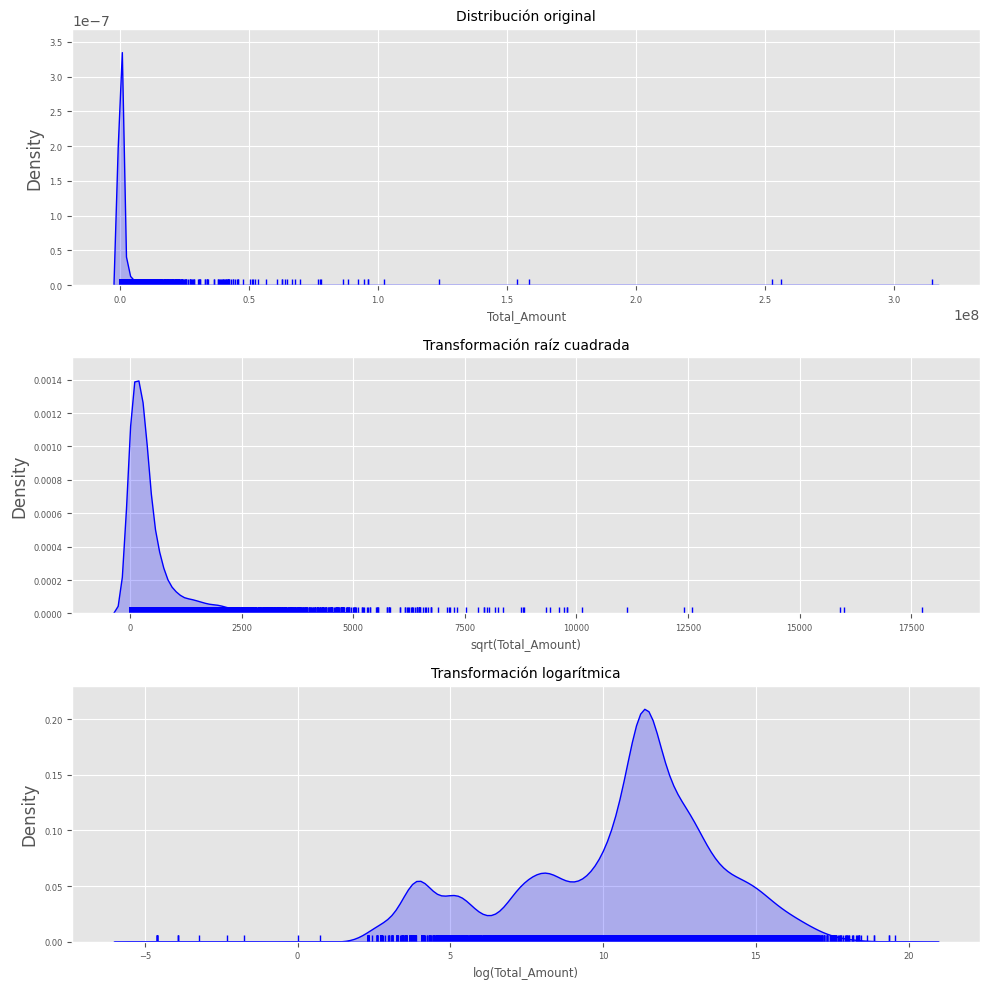

In [239]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
sns.distplot(
    DataFrame_short.Total_Amount,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('Total_Amount', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.distplot(
    np.sqrt(DataFrame_short.Total_Amount),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(Total_Amount)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.distplot(
    np.log(DataFrame_short.Total_Amount),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(Total_Amount)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

**Raíz cuadrada parece la mas interesante en este caso**

In [240]:
DataFrame_short['Total_Amount'].describe()

count    1.677200e+04
mean     1.010612e+06
std      5.873179e+06
min      1.000000e-02
25%      4.750453e+03
50%      7.714000e+04
75%      2.914669e+05
max      3.150001e+08
Name: Total_Amount, dtype: float64

In [241]:
DataFrame_short['Total_Amount'] = np.log(DataFrame_short.Total_Amount)

In [242]:
DataFrame_short['Total_Amount'].describe()

count    16772.000000
mean        10.470044
std          3.308478
min         -4.605170
25%          8.465995
50%         11.253377
75%         12.582682
max         19.568083
Name: Total_Amount, dtype: float64

## Separación de entrenamiento y Test

In [243]:
Entrenamiento = DataFrame_short.loc[:,DataFrame_short.columns != 'Decision']

In [244]:
Entrenamiento

,Total_Amount,Delivery_Year,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr",Delivery_Quarter_1,Delivery_Quarter_2,Delivery_Quarter_3,Delivery_Quarter_4,Region_Japon,Region_EMEA,Region_Americas,Region_Apac,Region_Middle_East
0,15.635076,2016,1,1,0,1,0,0,0,1,0,0,0
1,10.940740,2016,0,0,1,0,0,0,0,1,0,0,0
2,11.336971,2016,0,0,1,0,0,0,0,0,1,0,0
3,15.819943,2018,0,1,1,0,0,0,0,0,1,0,0
4,16.407566,2018,0,1,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16942,11.702880,2016,1,1,1,0,0,0,0,1,0,0,0
16943,11.597520,2016,1,1,0,1,0,0,0,1,0,0,0
16944,11.702880,2016,1,1,1,0,0,0,0,1,0,0,0
16945,14.668562,2016,1,1,0,1,0,0,0,0,1,0,0


In [245]:
#Test = DataFrame_short[(DataFrame_short['Delivery_Year']== 2018) & (DataFrame_short['Delivery_Quarter'] == 1)]
#Test = Test['Decision']
#Test

In [246]:
Test = DataFrame_short.loc[:,'Decision']


In [247]:
Entrenamiento.shape, Test.shape, DataFrame_short.shape

((16772, 13), (16772,), (16772, 14))

##Entrenamiento y Test

Para poder entrenar X e Y tengo que tener la misma cant de filas XD

In [248]:
X_Entrenamiento, X_EntrenamientoTest, Y_TestEntrenamiento, Y_TestTest = train_test_split(Entrenamiento,Test,test_size = 0.2, random_state = 0)

In [249]:
X_Entrenamiento.shape, X_EntrenamientoTest.shape, Y_TestEntrenamiento.shape, Y_TestTest.shape

((13417, 13), (3355, 13), (13417,), (3355,))

In [250]:
X_PruebaE = X_Entrenamiento

In [251]:
Y_PruebaE = Y_TestEntrenamiento

In [252]:
xg_clas = XGBClassifier(colsample_bytree = 0.8, gamma = 1, learning_rate = 0.01, max_depth = 20, min_child_weight = 1, n_estimators = 200, subsample = 0.8)

In [253]:
xg_clas.fit(X_Entrenamiento,Y_TestEntrenamiento)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1,
              learning_rate=0.01, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [254]:
preds = xg_clas.predict(X_EntrenamientoTest)

In [255]:
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(Y_TestTest, preds))
print(classification_report(Y_TestTest, preds))
pd.crosstab(Y_TestTest, preds)

0.8286140089418778
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1466
           1       0.82      0.88      0.85      1889

    accuracy                           0.83      3355
   macro avg       0.83      0.82      0.82      3355
weighted avg       0.83      0.83      0.83      3355



col_0,0,1
Decision,,
0,1112,354
1,221,1668


In [256]:
value_pred = pd.DataFrame()
value_pred['pred'] = preds
value_pred['pred'].value_counts()

1    2022
0    1333
Name: pred, dtype: int64

In [257]:
rmse = np.sqrt(mean_squared_error(Y_TestTest, preds))
print("RMSE: %f" % (rmse))
accuracy = accuracy_score(Y_TestTest, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

RMSE: 0.413988
Accuracy: 82.86%


In [258]:
loss = log_loss(Y_TestTest, preds)
print(f"Log Loss is {loss}")

Log Loss is 5.919546791226209


learning rate 0.1 57%   |||||  n_estimators 10

""            0.05 56%   ||        ""

""            0.5 60%     |||       ""

## Importancia de los features
Le paso una wea ya entrenada 

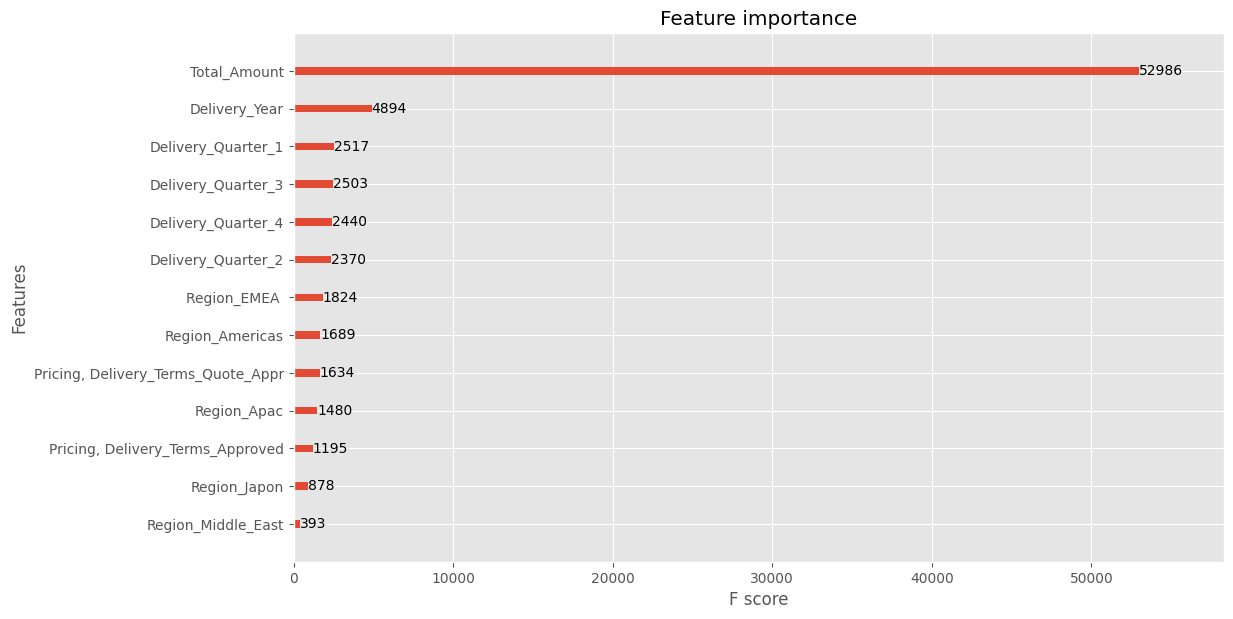

In [259]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_clas)

##Visualizacion del arbol

In [260]:
#plt.rcParams['figure.figsize'] = [20, 20]
#xgb.plot_tree(xg_clas, num_trees = 1)

#Test

##DF

In [261]:
DataFrame_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Archivos para leer /Tp2/Test_TP2_Datos_2020-2C.csv')

In [262]:
DataFrame_test.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Prod_Category_A
0,6140,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_171,Product_Name_332,EUR,0.325,USD,0.36761,5/1/2019,5/31/2019,2019 - 5,Q2,2019,NaT,0,EUR,162240.0,EUR,367419.0,Prod_Category_A_None
1,6146,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_167,Product_Name_315,EUR,0.320,USD,0.36195,5/1/2019,5/31/2019,2019 - 5,Q2,2019,NaT,0,EUR,78624.0,EUR,367419.0,Prod_Category_A_None
2,6151,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_140,Product_Name_241,EUR,0.275,USD,0.31105,5/1/2019,5/31/2019,2019 - 5,Q2,2019,NaT,0,EUR,126555.0,EUR,367419.0,Prod_Category_A_None
3,6118,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,10690,6504,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/25/2019,Person_Name_13,Product_Family_171,Product_Name_328,EUR,0.325,USD,0.36761,6/1/2019,6/28/2019,2019 - 6,Q2,2019,NaT,1,EUR,243360.0,EUR,757783.5,Prod_Category_A_None
4,6124,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,10690,6504,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/25/2019,Person_Name_13,Product_Family_167,Product_Name_315,EUR,0.320,USD,0.36195,6/1/2019,6/29/2019,2019 - 6,Q2,2019,NaT,0,EUR,157248.0,EUR,757783.5,Prod_Category_A_None


In [263]:
DataFrame_test.shape

(2551, 51)

In [264]:
DataFrame_test['Opportunity_ID'].value_counts()

12266    26
10973    24
11089    18
11869    15
11248    11
         ..
11778     1
12181     1
12179     1
11518     1
11488     1
Name: Opportunity_ID, Length: 1567, dtype: int64

##Conversion


In [265]:
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'JPY', 'Total_Amount'] = DataFrame_test['Total_Amount']*0.0096
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'JPY', 'Total_Amount_Currency'] = 'USD'

DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'EUR', 'Total_Amount'] = DataFrame_test['Total_Amount']*1.17
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'EUR', 'Total_Amount_Currency'] = 'USD'

DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'AUD', 'Total_Amount'] = DataFrame_test['Total_Amount']*0.70
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'AUD', 'Total_Amount_Currency'] = 'USD'

DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'GBP', 'Total_Amount'] = DataFrame_test['Total_Amount']*1.29
DataFrame_test.loc[DataFrame_test['Total_Amount_Currency'] == 'GBP', 'Total_Amount_Currency'] = 'USD'

##Filtro por las columnas que voy a usar

In [266]:
DataFrame_test_short = DataFrame_test[['Region', 'Total_Amount', 'Delivery_Year', 'Delivery_Quarter','Pricing, Delivery_Terms_Approved','Pricing, Delivery_Terms_Quote_Appr']].rename(columns={'Stage': 'Decision'})
DataFrame_test_short.head()

,Region,Total_Amount,Delivery_Year,Delivery_Quarter,"Pricing, Delivery_Terms_Approved","Pricing, Delivery_Terms_Quote_Appr"
0,EMEA,189820.80,2019,Q2,1,1
1,EMEA,91990.08,2019,Q2,1,1
2,EMEA,148069.35,2019,Q2,1,1
3,EMEA,284731.20,2019,Q2,1,1
4,EMEA,183980.16,2019,Q2,1,1


##Encoding

Agrego log 15/2

In [267]:
DataFrame_test_short['Total_Amount'] = np.log(DataFrame_test_short.Total_Amount)

**Encoding Quarters**

In [268]:
DataFrame_test_short['Delivery_Quarter_1'] = np.where(DataFrame_test_short['Delivery_Quarter'] == 'Q1',1,0)

In [269]:
DataFrame_test_short['Delivery_Quarter_2'] = np.where(DataFrame_test_short['Delivery_Quarter'] == 'Q2',1,0)

In [270]:
DataFrame_test_short['Delivery_Quarter_3'] = np.where(DataFrame_test_short['Delivery_Quarter'] == 'Q3',1,0)

In [271]:
DataFrame_test_short['Delivery_Quarter_4'] = np.where(DataFrame_test_short['Delivery_Quarter'] == 'Q4',1,0)

In [272]:
DataFrame_test_short.drop('Delivery_Quarter', axis = 1, inplace = True)

**Encoding Region**

In [273]:
DataFrame_test_short['Region_Japon'] = np.where(DataFrame_test_short['Region'] == 'Japan',1,0)

In [274]:
DataFrame_test_short['Region_EMEA '] = np.where(DataFrame_test_short['Region'] == 'EMEA',1,0)

In [275]:
DataFrame_test_short['Region_Americas'] = np.where(DataFrame_test_short['Region'] == 'Americas',1,0)

In [276]:
DataFrame_test_short['Region_Apac'] = np.where(DataFrame_test_short['Region'] == 'APAC',1,0)

In [277]:
DataFrame_test_short['Region_Middle_East'] = np.where(DataFrame_test_short['Region'] == 'Middle East',1,0)

In [278]:
DataFrame_test_short.drop('Region', axis = 1, inplace = True)

##Predicción

**Test**

In [279]:
pred_posta = xg_clas.predict(DataFrame_test_short)

In [280]:
subir = pd.DataFrame()
subir['Opportunity_ID'] = DataFrame_test['Opportunity_ID']
subir['target'] = pred_posta
subir.sort_values('Opportunity_ID',inplace = True)
subir = subir.drop_duplicates('Opportunity_ID',keep = 'last')
subir.set_index('Opportunity_ID', inplace = True)
subir

,target
Opportunity_ID,
10689,0
10690,0
10691,1
10692,0
10693,1
...,...
12364,1
12365,1
12366,1


In [281]:
subir['target'].value_counts()

0    799
1    768
Name: target, dtype: int64

In [282]:
csv3 = subir.to_csv('xgboost_pred_4.csv')
files.download('xgboost_pred_4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Grid Search de hiperparametros



In [283]:
"""
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        

SyntaxError: ignored

In [ ]:
"""
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.3, 0.6, 0.8],
        'max_depth': [3, 5, 10, 20],
        'learning_rate' : [0.1, 0.01, 0.001],
        'n_estimators' : [10, 100, 150, 200]
        }
        """

In [ ]:
"""xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=True, nthread=1)

In [ ]:
"""
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(Entrenamiento,Test), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(Entrenamiento, Test)
timer(start_time) # timing ends here for "start_time" variable

In [ ]:
"""
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)

In [ ]:
"""
grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='roc_auc', n_jobs=4, cv=skf.split(Entrenamiento,Test), verbose=3 )
grid.fit(Entrenamiento, Test)
print('\n All results:')
print(grid.cv_results_)
print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid.best_params_)
results = pd.DataFrame(grid.cv_results_)
results.to_csv('xgb-grid-search-results-01.csv', index=False)

In [ ]:
#files.download('xgb-random-grid-search-results-01.csv')

In [ ]:
#files.download('xgb-grid-search-results-01.csv')